In [7]:
import numpy as np
import pickle
import time
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from iminuit import Minuit, cost
from iminuit.cost import LeastSquares
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta

In [2]:
data = pd.read_pickle(r'Run11_list.pkl')
ptrig = pd.read_pickle(r'PTRIG.pkl')

In [3]:
Brd = np.array(data["Brd"])
Ch = np.array(data["Ch"])
LG = np.array(data["LG"])
HG = np.array(data["HG"])
Tstamp_us = np.array(data["Tstamp_us"])
Tstamp_utc = np.array(data["Tstamp_utc"])
event_ids = np.array(data["event_ids"])

ptrig_Brd = np.array(ptrig["board"])
ptrig_Ch = np.array(ptrig["channel"])
ptrig_LG_mean = np.array(ptrig["LG_mean"])
ptrig_LG_sigma = np.array(ptrig["LG_sigma"])
ptrig_HG_mean = np.array(ptrig["HG_mean"])
ptrig_HG_sigma = np.array(ptrig["HG_sigma"])

In [4]:
# Get unique event IDs and their indices
unique_event_ids, event_indices = np.unique(event_ids, return_index=True)

# Calculate average Tstamp_us for each event ID
average_timestamps = []
for i, event_id in enumerate(unique_event_ids):
    # Calculate the range of indices for the current event ID
    start_index = event_indices[i]
    end_index = event_indices[i+1] if i < len(event_indices) - 1 else len(Tstamp_us)
    
    # Calculate average timestamp for the current event ID
    timestamps_for_event = Tstamp_us[start_index:end_index]
    average_timestamp = np.mean(timestamps_for_event)
    average_timestamps.append(average_timestamp)
average_timestamps_utc = [datetime.utcfromtimestamp(tstamp_us / 1e6) for tstamp_us in average_timestamps]
average_timestamps = np.array(average_timestamps) - average_timestamps[0]

26.48732755571022


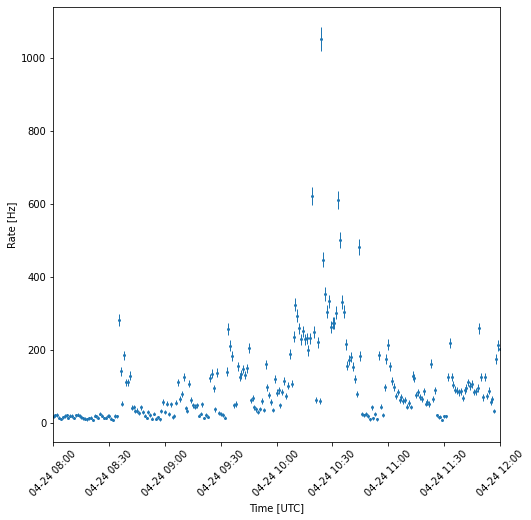

In [8]:
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

fig = plt.figure(figsize=(8, 8))

# Calculate the range of your data
data_range = max(average_timestamps) - min(average_timestamps)

# Calculate the number of bins needed to represent 1-minute intervals
num_mins = data_range / (60 * 1e6)  # Convert microseconds to minutes
num_bins = int(np.ceil(num_mins))

print(len(average_timestamps) / (data_range / (60 * 1e6)))
# Calculate the bin edges
bin_edges = np.linspace(min(average_timestamps), max(average_timestamps), num_bins + 1)

# Compute histogram
h, bins = np.histogram(average_timestamps, bins=bin_edges)

bin_centers_us = 0.5 * (bins[:-1] + bins[1:])


# Convert bin centers to hours
bin_centers_mins = bin_centers_us / (60 * 1e6)  # Convert microseconds to minutes

# Convert counts to rates (Hz)
bin_width_mins = (bins[1] - bins[0]) / (60 * 1e6)  # Convert microseconds to minutes
h_rate = h / bin_width_mins

# Define the start time of the file
start_time = average_timestamps_utc[0]

# Calculate the bin centers in datetime format
bin_centers_datetime = [start_time + timedelta(microseconds=us) for us in bin_centers_us]

# Plot
plt.errorbar(bin_centers_datetime, h_rate, yerr=np.sqrt(h)/bin_width_mins, fmt='o', ms=3, ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)

date_format = DateFormatter("%m-%d %H:%M")
plt.gca().xaxis.set_major_formatter(date_format)
# Set x-limits to be within a certain time period
plt.xlim(datetime(2024, 4, 24, 8, 0), datetime(2024, 4, 24, 12, 0))  # Example range from 6:30 to 7:00


plt.xlabel("Time [UTC]")
plt.ylabel("Rate [Hz]")
plt.xticks(rotation=45)
plt.show()

In [9]:
LG_pedsub = np.zeros_like(LG)  # Initialize LG_pedsub array with zeros

for i in range(len(LG)):
    # Find corresponding board and channel
    board = Brd[i]
    channel = Ch[i]
    
    # Find index of board and channel in ptrig arrays
    index = np.where((ptrig_Brd == board) & (ptrig_Ch == channel))[0]
    
    if len(index) == 1:  # If a matching index is found
        index = index[0]
        # Calculate the difference
        difference = LG[i] - ptrig_LG_mean[index]
        # Check if the difference is less than the corresponding sigma value
        if ptrig_LG_sigma[index] == 100:
            if np.abs(difference) < 4 * 8:
                LG_pedsub[i] = 0
            else:
                LG_pedsub[i] = difference
        elif np.abs(difference) < 4 * ptrig_LG_sigma[index]:
            LG_pedsub[i] = 0
        else:
            # Subtract corresponding LG_mean value from LG
            LG_pedsub[i] = difference
    else:
        # Handle cases where no matching index is found
        print(f"No matching index found for board {board} and channel {channel}")


In [10]:
HG_pedsub = np.zeros_like(HG)  # Initialize LG_pedsub array with zeros

for i in range(len(HG)):
    # Find corresponding board and channel
    board = Brd[i]
    channel = Ch[i]
    
    # Find index of board and channel in ptrig arrays
    index = np.where((ptrig_Brd == board) & (ptrig_Ch == channel))[0]
    
    if len(index) == 1:  # If a matching index is found
        index = index[0]
        # Calculate the difference
        difference = HG[i] - ptrig_HG_mean[index]
        # Check if the difference is less than the corresponding sigma value
        if ptrig_HG_sigma[index] == 100:
            if np.abs(difference) < 4 * 8:
                HG_pedsub[i] = 0
            else:
                HG_pedsub[i] = difference
        elif np.abs(difference) < 4 * ptrig_HG_sigma[index]:
            HG_pedsub[i] = 0
        else:
            # Subtract corresponding LG_mean value from LG
            HG_pedsub[i] = difference
    else:
        # Handle cases where no matching index is found
        print(f"No matching index found for board {board} and channel {channel}")

In [53]:
def plot_histograms(board_number, events, ch, brd, title, high):
    # Create subplots for each channel
    fig, axs = plt.subplots(4, 16, figsize=(32, 8), sharey=True, sharex=True)
    fig.suptitle(title, fontsize=40, y=1)
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['savefig.facecolor'] = 'white'
    plt.rcParams['savefig.bbox'] = 'tight'

    for i in range(4):
        for j in range(16):
            channel_number = i * 16 + j
            ax = axs[i, j] if len(axs.shape) > 1 else axs[j]  # For 1D array indexing
            mask = (ch == channel_number) & (brd == board_number) & (events != 0)

            if len(events[mask]) != 0:
                # Create histogram
                h, bins = np.histogram(events[mask], bins=50, range=(0, high))
                bin_centers = 0.5 * (bins[:-1] + bins[1:])
                errors = np.sqrt(h)

                # Plot error bar plot
                ax.errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0,
                            elinewidth=1, markeredgewidth=0)

                initial_params = [max(h), np.mean(events[mask]), np.std(events[mask])]
                mask = h > 0

                ax.set_yscale("log")
                ax.set_ylim(1, 10e4)

            # Set labels
            ax.set_title(f'Ch {channel_number}', fontsize=20, pad=-18, loc='center')
            if i == 3:  # Bottom most row
                ax.set_xlabel('Value [ADC]', fontsize=20)
            if j == 0:  # Left most column
                ax.set_ylabel('Count', fontsize=20)

    # Adjust layout
    plt.tight_layout(pad=0.0)
    plt.subplots_adjust(hspace=0.0, wspace=0.0)
    plt.show()

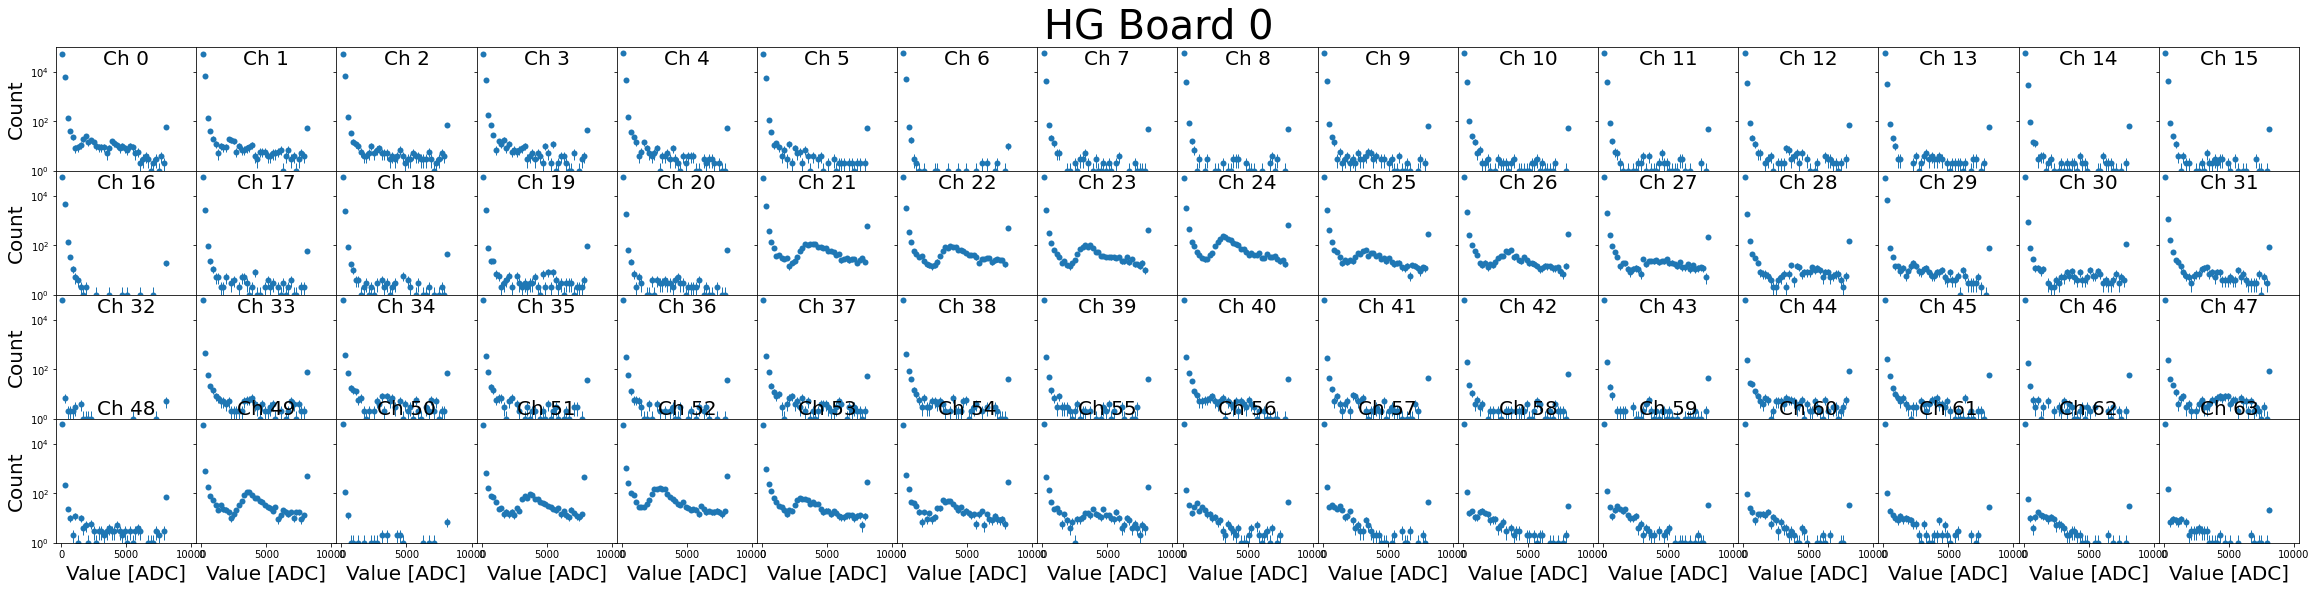

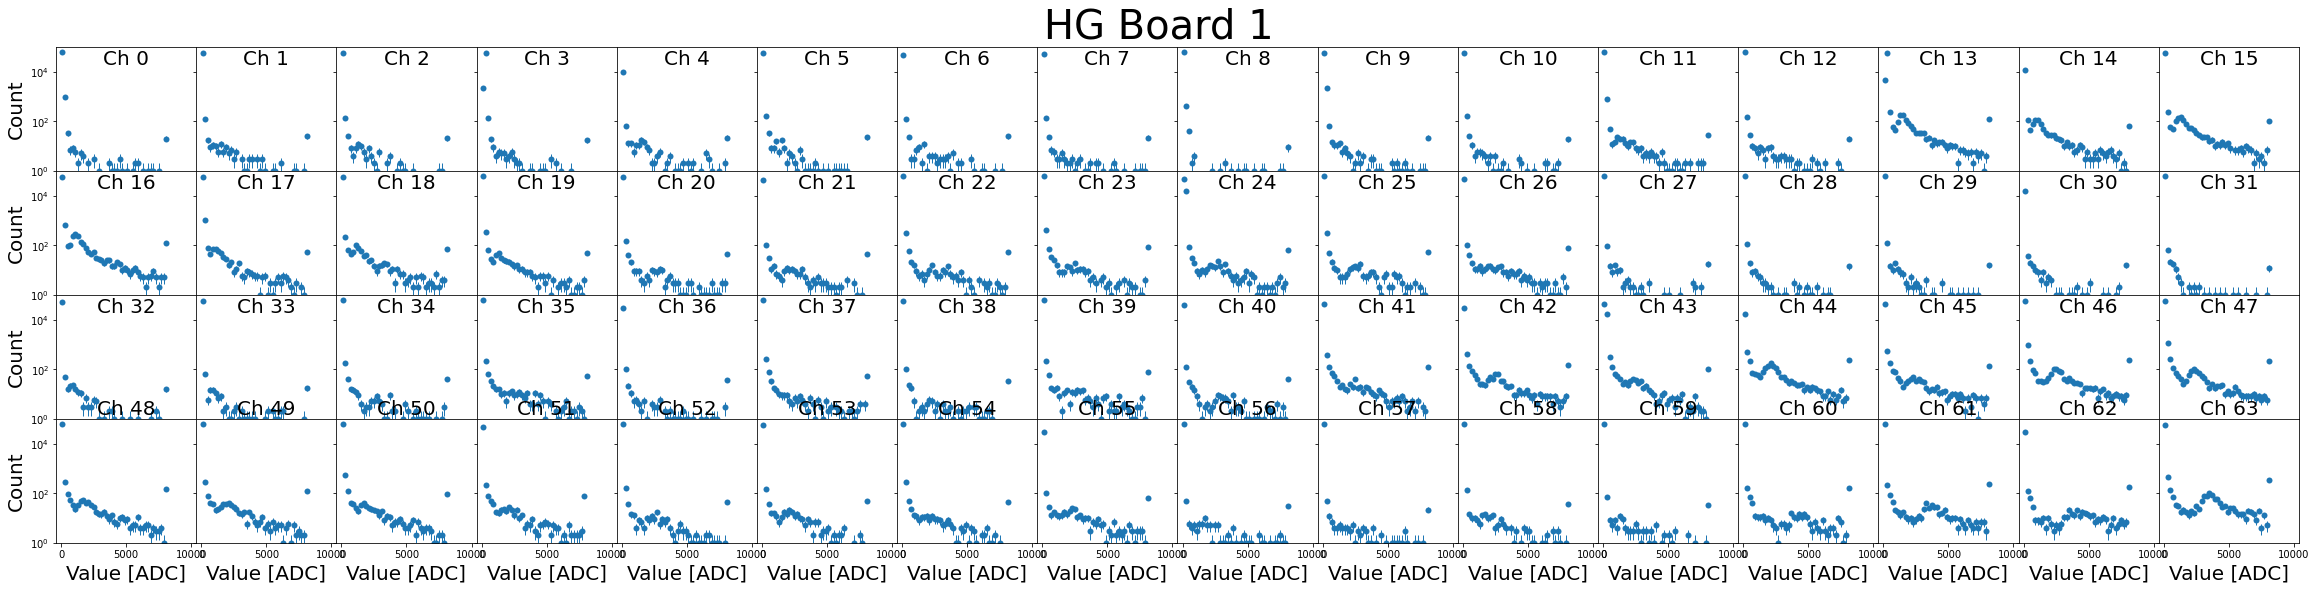

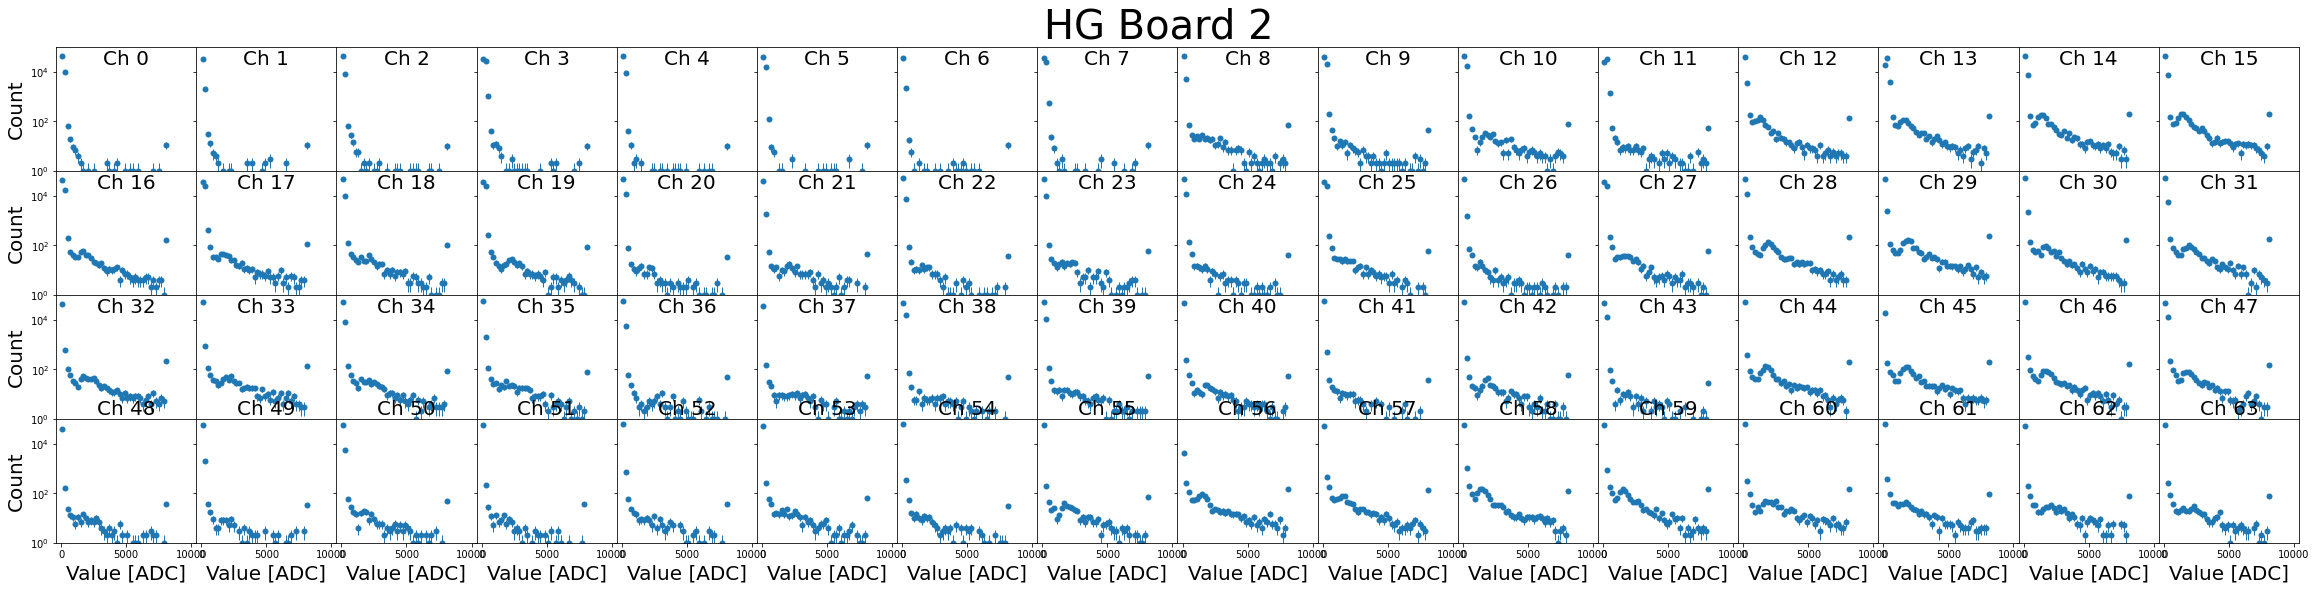

In [57]:
plot_histograms(0, HG, Ch, Brd, "HG Board 0", 10000)
plot_histograms(1, HG, Ch, Brd, "HG Board 1", 10000)
plot_histograms(2, HG, Ch, Brd, "HG Board 2", 10000)

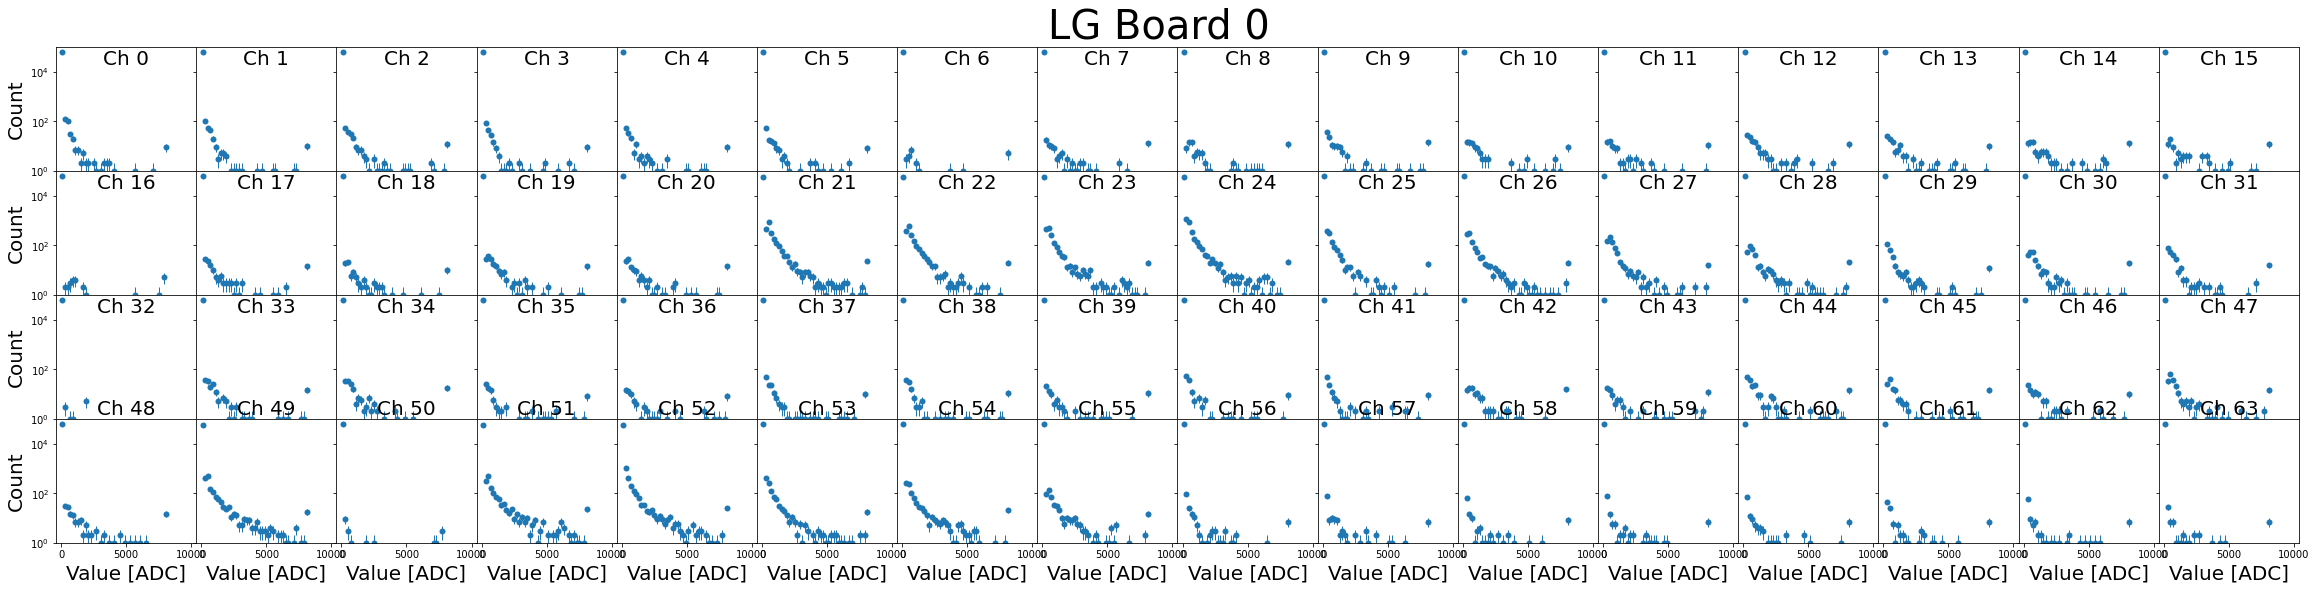

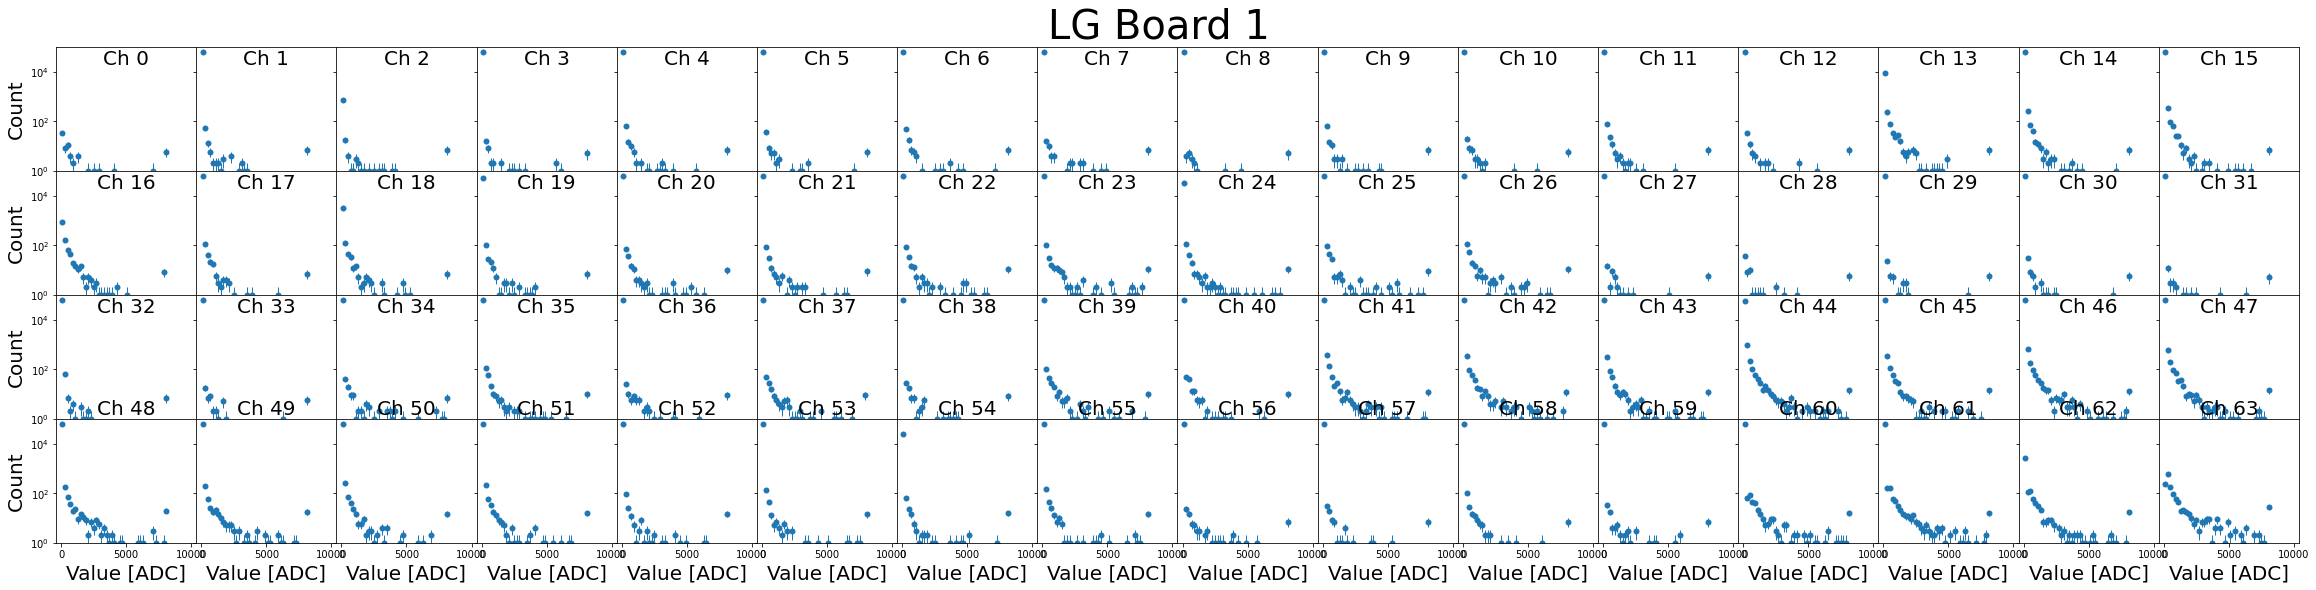

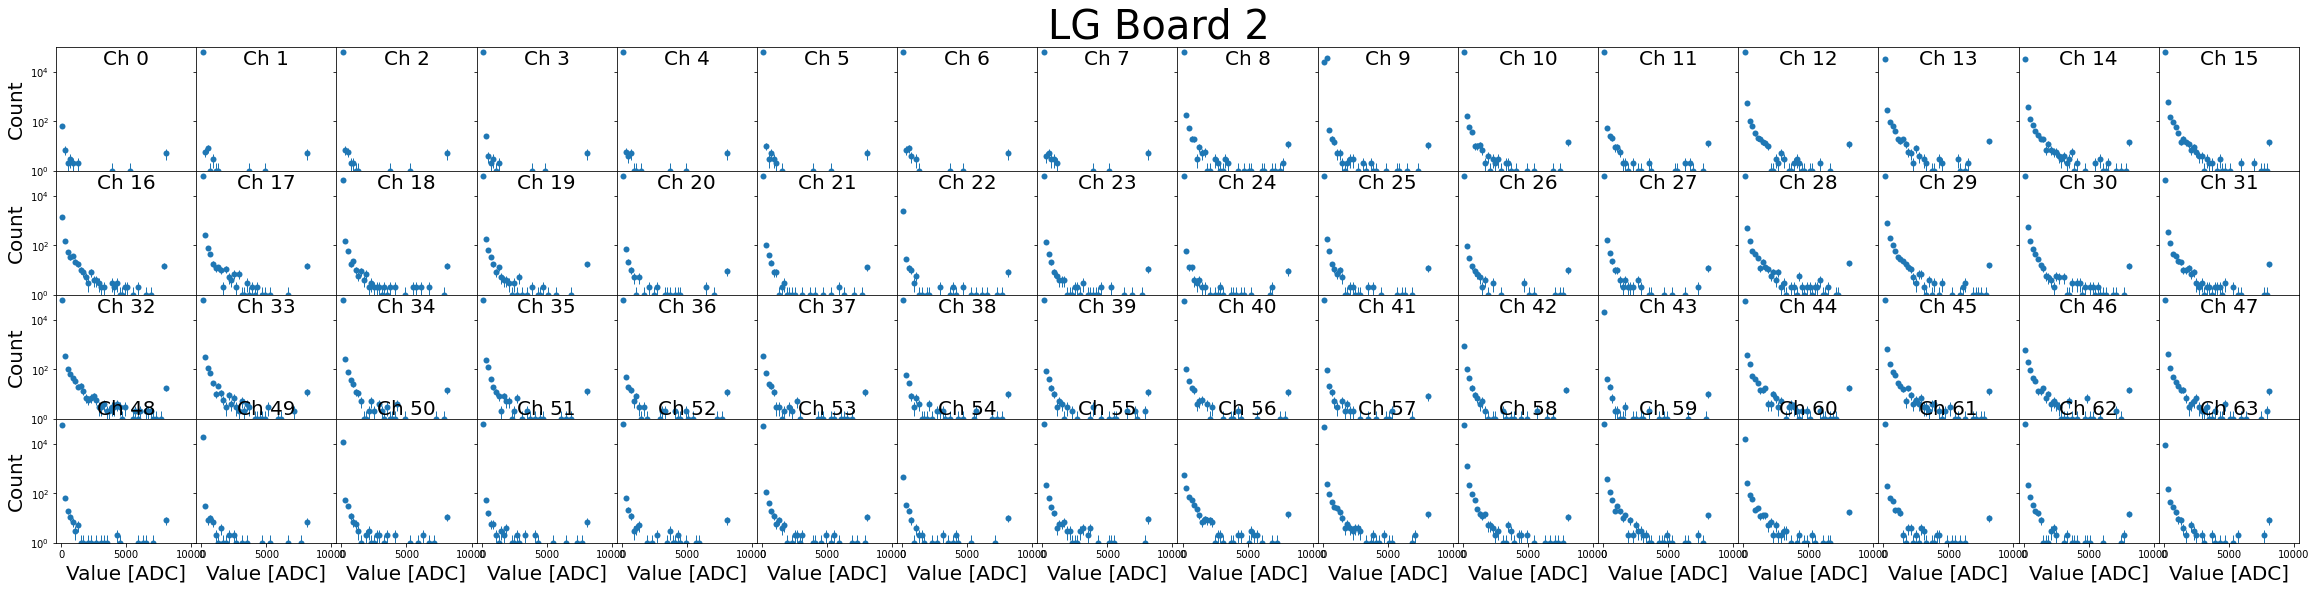

In [58]:
plot_histograms(0, LG, Ch, Brd, "LG Board 0", 10000)
plot_histograms(1, LG, Ch, Brd, "LG Board 1", 10000)
plot_histograms(2, LG, Ch, Brd, "LG Board 2", 10000)

In [15]:
unique_event_ids, event_counts = np.unique(event_ids, return_counts=True)

# Use numpy's bincount to efficiently calculate the sum of LG values for each unique event_id
LG_sums = np.bincount(event_ids, weights=LG_pedsub)

# Since bincount will include zeros for event_ids that are not present, 
# we need to trim the resulting LG_sums array to match the length of unique_event_ids
LG_sums = LG_sums[unique_event_ids]

In [16]:
unique_event_ids, event_counts = np.unique(event_ids, return_counts=True)

# Use numpy's bincount to efficiently calculate the sum of LG values for each unique event_id
HG_sums = np.bincount(event_ids, weights=HG_pedsub)

# Since bincount will include zeros for event_ids that are not present, 
# we need to trim the resulting LG_sums array to match the length of unique_event_ids
HG_sums = HG_sums[unique_event_ids]

Text(0.5, 1.0, 'LG ADC Event Sum')

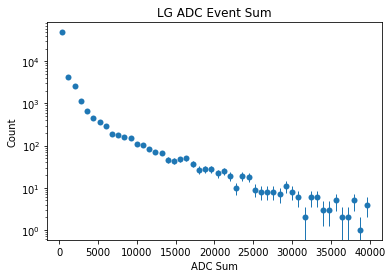

In [19]:
h, bins = np.histogram(LG_sums, bins=50, range=(0,40000))
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(h)
plt.errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)
plt.yscale("log")
plt.ylabel("Count")
plt.xlabel("ADC Sum")
plt.title("LG ADC Event Sum")

Text(0.5, 1.0, 'HG ADC Event Sum')

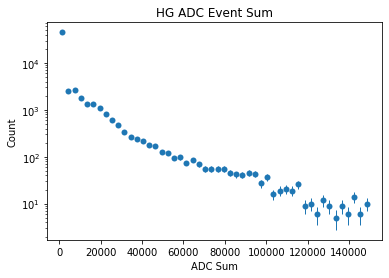

In [22]:
h, bins = np.histogram(HG_sums, bins=50, range=(0,150000))
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(h)
plt.errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)
plt.yscale("log")
plt.ylabel("Count")
plt.xlabel("ADC Sum")
plt.title("HG ADC Event Sum")

In [53]:
def plot_histograms(board_number, LG, HG ch, brd, title):
    # Create subplots for each channel
    fig, axs = plt.subplots(4, 16, figsize=(32, 8), sharey=True, sharex=True)
    fig.suptitle(title, fontsize=40, y=1)
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['savefig.facecolor'] = 'white'
    plt.rcParams['savefig.bbox'] = 'tight'

    for i in range(4):
        for j in range(16):
            channel_number = i * 16 + j
            ax = axs[i, j] if len(axs.shape) > 1 else axs[j]  # For 1D array indexing
            mask = (ch == channel_number) & (brd == board_number) & (events != 0)

            if len(events[mask]) != 0:
                # Create histogram
                h, bins = np.histogram(events[mask], bins=50, range=(0, high))
                bin_centers = 0.5 * (bins[:-1] + bins[1:])
                errors = np.sqrt(h)

                # Plot error bar plot
                ax.errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0,
                            elinewidth=1, markeredgewidth=0)

                initial_params = [max(h), np.mean(events[mask]), np.std(events[mask])]
                mask = h > 0

                ax.set_yscale("log")
                ax.set_ylim(1, 10e4)

            # Set labels
            ax.set_title(f'Ch {channel_number}', fontsize=20, pad=-18, loc='center')
            if i == 3:  # Bottom most row
                ax.set_xlabel('Value [ADC]', fontsize=20)
            if j == 0:  # Left most column
                ax.set_ylabel('Count', fontsize=20)

    # Adjust layout
    plt.tight_layout(pad=0.0)
    plt.subplots_adjust(hspace=0.0, wspace=0.0)
    plt.show()